# Portfolio Allocation Strategy

This notebook demonstrates a buy-and-hold strategy with a custom portfolio allocation:
- Define multiple symbols with specific weight allocations
- Buy and hold portfolio with rebalancing on first day
- Track performance with comprehensive pyfolio analysis
- Compare against single-asset strategies

## Setup

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from zipline import run_algorithm
from zipline.api import (
    order_target_percent,
    symbol,
    record,
    schedule_function,
    date_rules,
    time_rules,
)
from zipline.utils.progress import enable_progress_logging

# Enable logging
logging.basicConfig(level=logging.INFO, force=True)
enable_progress_logging(algo_name='Portfolio-Allocation', update_interval=10)

## Portfolio Configuration

Define your portfolio allocation below. Weights should sum to 1.0 (100%).

**Example Portfolios:**
- **60/40 Portfolio**: 60% stocks (SPY), 40% bonds (TLT)
- **FAANG Portfolio**: Equal weight across tech giants
- **Sector Diversification**: Spread across different sectors
- **Custom Allocation**: Any combination you want to test

In [3]:
# PORTFOLIO CONFIGURATION
# Define your portfolio as a dictionary: {symbol: weight}
# Weights should sum to 1.0 (100% of portfolio)

# Example 1: Classic 60/40 Portfolio (60% stocks, 40% bonds)
PORTFOLIO = {
    'SPY': 0.60,   # S&P 500 ETF
    'TLT': 0.40,   # 20+ Year Treasury Bond ETF
}

# Example 2: FAANG Equal Weight
# PORTFOLIO = {
#     'AAPL': 0.20,  # Apple
#     'AMZN': 0.20,  # Amazon
#     'GOOGL': 0.20, # Google
#     'META': 0.20,  # Meta (Facebook)
#     'NFLX': 0.20,  # Netflix
# }

# Example 3: Sector Diversification
# PORTFOLIO = {
#     'SPY': 0.30,   # Large Cap Stocks
#     'QQQ': 0.25,   # Tech (Nasdaq 100)
#     'IWM': 0.15,   # Small Cap
#     'TLT': 0.20,   # Bonds
#     'GLD': 0.10,   # Gold
# }

# Example 4: Custom Tech/Growth Allocation
# PORTFOLIO = {
#     'AAPL': 0.25,
#     'MSFT': 0.25,
#     'NVDA': 0.20,
#     'TSLA': 0.15,
#     'GOOGL': 0.15,
# }

# Validate portfolio
total_weight = sum(PORTFOLIO.values())
print(f"Portfolio Configuration:")
print(f"{'='*50}")
for symbol_name, weight in PORTFOLIO.items():
    print(f"  {symbol_name:8s}: {weight*100:5.1f}%")
print(f"{'='*50}")
print(f"Total: {total_weight*100:.1f}%")

if abs(total_weight - 1.0) > 0.01:
    print(f"\n⚠️  Warning: Weights sum to {total_weight*100:.1f}%, not 100%")
    print(f"   Portfolio will be normalized to 100%")
else:
    print(f"\n✓ Portfolio weights validated")

Portfolio Configuration:
  SPY     :  60.0%
  TLT     :  40.0%
Total: 100.0%

✓ Portfolio weights validated


## Strategy Implementation

Buy and hold portfolio with specified allocation.

In [4]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    # Convert portfolio dict to symbol objects
    context.portfolio_weights = {}
    for ticker, weight in PORTFOLIO.items():
        context.portfolio_weights[symbol(ticker)] = weight
    
    # Normalize weights to sum to 1.0
    total = sum(context.portfolio_weights.values())
    context.portfolio_weights = {
        asset: weight / total 
        for asset, weight in context.portfolio_weights.items()
    }
    
    # Track if we've made our initial purchase
    context.has_bought = False
    
    logging.info(f"Strategy initialized")
    logging.info(f"  Portfolio: {len(context.portfolio_weights)} assets")
    for asset, weight in context.portfolio_weights.items():
        logging.info(f"    {asset.symbol}: {weight*100:.1f}%")


def handle_data(context, data):
    """
    Called every day (or bar).
    """
    # Buy on the first day (only for tradeable assets)
    if not context.has_bought:
        # Check which assets are tradeable
        tradeable_assets = [asset for asset in context.portfolio_weights.keys() 
                           if data.can_trade(asset)]
        
        if len(tradeable_assets) == 0:
            return  # Wait for tradeable assets
        
        # Calculate adjusted weights for tradeable assets only
        tradeable_weight_sum = sum(context.portfolio_weights[asset] 
                                   for asset in tradeable_assets)
        
        # Place orders for each tradeable asset
        for asset in context.portfolio_weights.keys():
            if data.can_trade(asset):
                # Adjust weight proportionally for tradeable assets
                adjusted_weight = context.portfolio_weights[asset] / tradeable_weight_sum
                order_target_percent(asset, adjusted_weight)
                
                price = data.current(asset, 'price')
                logging.info(f"Bought {asset.symbol} at ${price:.2f} ({adjusted_weight*100:.1f}% allocation)")
        
        context.has_bought = True
        logging.info(f"Initial portfolio allocation complete")
    
    # Record daily values
    record(portfolio_value=context.portfolio.portfolio_value)
    record(cash=context.portfolio.cash)
    record(leverage=context.account.leverage)
    
    # Record individual asset values
    for asset in context.portfolio_weights.keys():
        if data.can_trade(asset):
            record(**{f"{asset.symbol}_price": data.current(asset, 'price')})


def analyze(context, perf):
    """
    Called after the backtest completes.
    """
    logging.info("\n" + "="*60)
    logging.info("BACKTEST RESULTS")
    logging.info("="*60)
    
    # Calculate returns
    start_value = perf['portfolio_value'].iloc[0]
    end_value = perf['portfolio_value'].iloc[-1]
    total_return = (end_value - start_value) / start_value * 100
    
    logging.info(f"Start date: {perf.index[0].date()}")
    logging.info(f"End date: {perf.index[-1].date()}")
    logging.info(f"")
    logging.info(f"Starting portfolio value: ${start_value:,.2f}")
    logging.info(f"Ending portfolio value: ${end_value:,.2f}")
    logging.info(f"Total return: {total_return:.2f}%")
    logging.info(f"")
    logging.info(f"Number of transactions: {len(perf[perf['transactions'].apply(len) > 0])}")
    logging.info("="*60)

## Run Backtest

Run the portfolio strategy from 2020 to 2023.

In [5]:
# Run the backtest
results = run_algorithm(
    start=pd.Timestamp('2020-01-01'),
    end=pd.Timestamp('2023-12-31'),
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=100000,  # Start with $100,000
    data_frequency='daily',
    bundle='sharadar',
)

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.
2025-11-18 07:40:48,305 INFO zipline.progress: [Portfolio-Allocation] Backtest initialized: 2020-01-02 to 2023-12-29 (1006 trading days)
2025-11-18 07:40:48,305 INFO zipline.progress: [Portfolio-Allocation] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:root:Strategy initialized
INFO:root:  Portfolio: 2 assets
INFO:root:    SPY: 60.0%
INFO:root:    TLT: 40.0%
INFO:root:Bought SPY at $298.39 (60.0% allocation)
INFO:root:Bought TLT at $116.35 (40.0% allocation)
INFO:root:Initial portfolio allocation complete


2025-11-18 07:40:48,801 INFO zipline.progress: [Portfolio-Allocation] ----------      0%  2020-01-15              1%          7.20         -0%               $1.2K
2025-11-18 07:40:48,828 INFO zipline.progress: [Portfolio-Allocation] ----------      1%  2020-01-30              3%          7.82         -1%               $2.5K
2025-11-18 07:40:48,855 INFO zipline.progress: [Portfolio-Allocation] ----------      2%  2020-02-13              4%          7.57         -1%               $4.1K
2025-11-18 07:40:48,881 INFO zipline.progress: [Portfolio-Allocation] ----------      3%  2020-02-28             -0%         -0.02         -5%                $-88
2025-11-18 07:40:48,909 INFO zipline.progress: [Portfolio-Allocation] ----------      4%  2020-03-13             -5%         -1.26        -13%              $-5.4K
2025-11-18 07:40:48,937 INFO zipline.progress: [Portfolio-Allocation] ----------      5%  2020-03-27             -4%         -0.57        -18%              $-4.0K
2025-11-18 07:40:48,97

INFO:zipline.finance.metrics.tracker:Simulated 1006 trading days
 first open: 2020-01-02 14:30:00+00:00
 last close: 2023-12-29 21:00:00+00:00


2025-11-18 07:40:51,485 INFO zipline.progress: 
[Portfolio-Allocation] ==================================================
2025-11-18 07:40:51,486 INFO zipline.progress: [Portfolio-Allocation] Backtest Complete!
2025-11-18 07:40:51,486 INFO zipline.progress: [Portfolio-Allocation] ==================================================
2025-11-18 07:40:51,486 INFO zipline.progress: [Portfolio-Allocation] Trading Days:     1006
2025-11-18 07:40:51,486 INFO zipline.progress: [Portfolio-Allocation] Total Return:     +24.84%
2025-11-18 07:40:51,486 INFO zipline.progress: [Portfolio-Allocation] Sharpe Ratio:     0.47
2025-11-18 07:40:51,487 INFO zipline.progress: [Portfolio-Allocation] Max Drawdown:     -27.0%
2025-11-18 07:40:51,487 INFO zipline.progress: [Portfolio-Allocation] Final Value:      $124,841
2025-11-18 07:40:51,487 INFO zipline.progress: [Portfolio-Allocation] ==================================================



INFO:root:
INFO:root:BACKTEST RESULTS
INFO:root:============================================================
INFO:root:Start date: 2020-01-02
INFO:root:End date: 2023-12-29
INFO:root:
INFO:root:Starting portfolio value: $100,000.00
INFO:root:Ending portfolio value: $124,840.76
INFO:root:Total return: 24.84%
INFO:root:
INFO:root:Number of transactions: 1
INFO:root:============================================================


## Analyze Results

Visualize portfolio performance and asset prices.

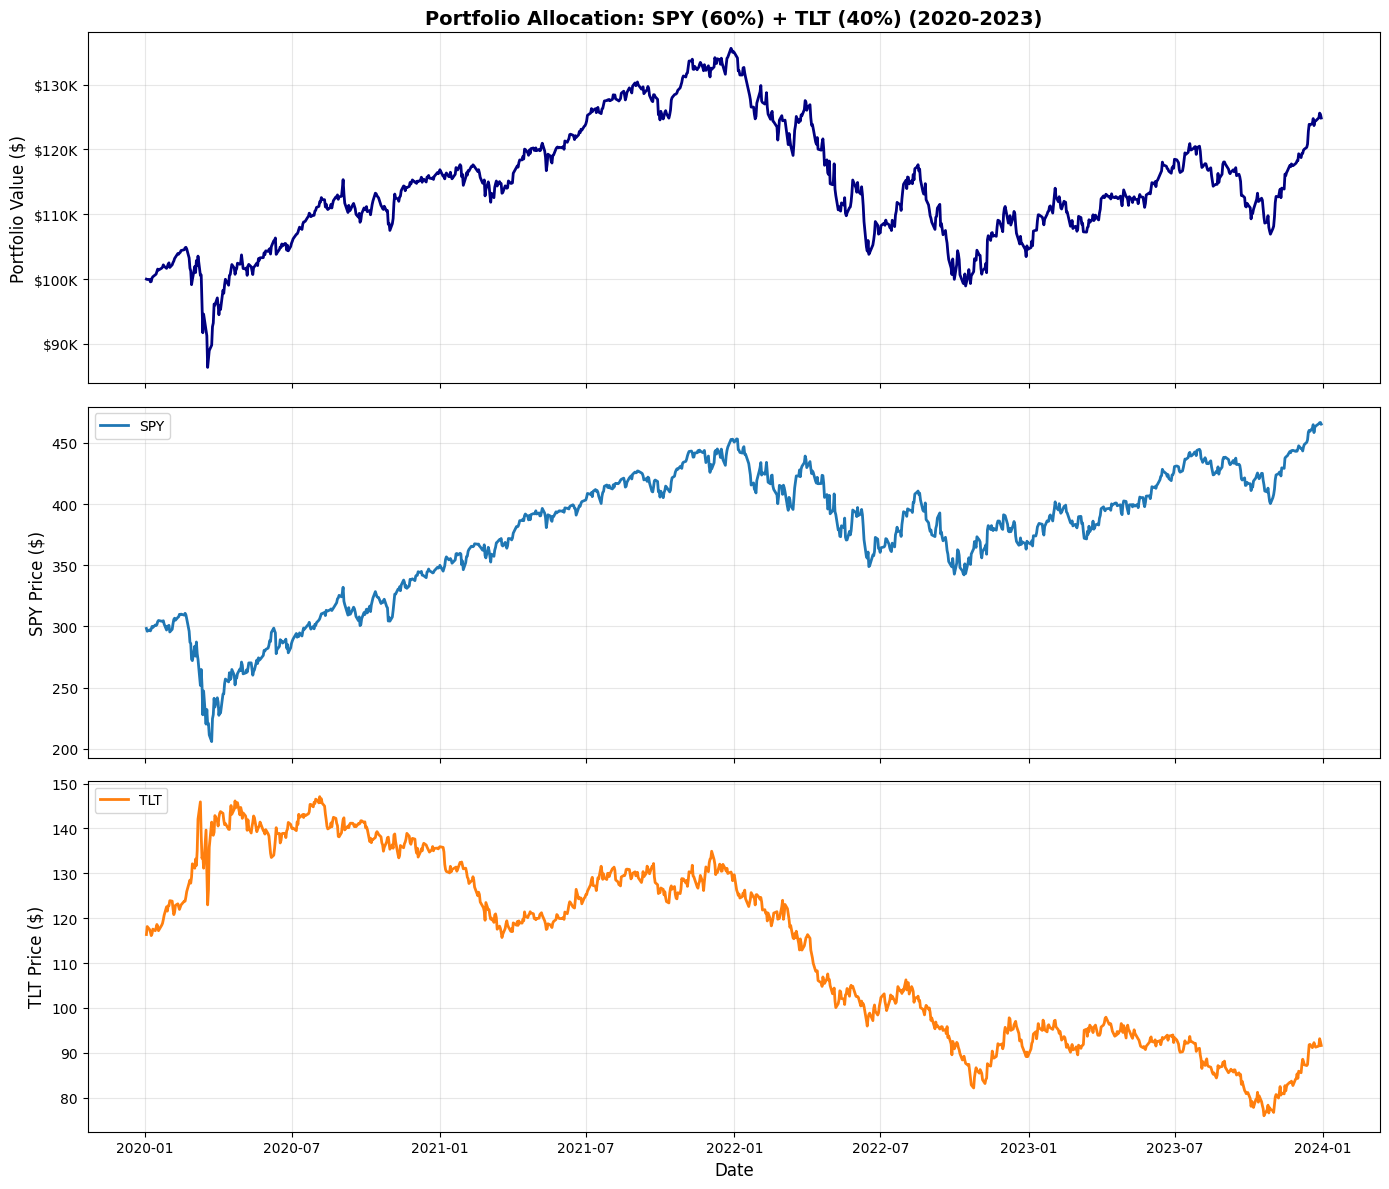


PORTFOLIO SUMMARY STATISTICS
Total Return: 24.84%
Max Portfolio Value: $135,586.23
Min Portfolio Value: $86,390.60
Final Portfolio Value: $124,840.76
Max Leverage: 1.00x


In [6]:
# Extract portfolio symbols for labels
portfolio_symbols = list(PORTFOLIO.keys())
start_year = results.index[0].year
end_year = results.index[-1].year

# Plot portfolio value and individual asset prices
num_assets = len(portfolio_symbols)
fig, axes = plt.subplots(num_assets + 1, 1, figsize=(14, 4 * (num_assets + 1)), sharex=True)

# Portfolio value
axes[0].plot(results.index, results['portfolio_value'], linewidth=2, color='navy')
axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[0].set_title(f'Portfolio Allocation: {" + ".join([f"{s} ({w*100:.0f}%)" for s, w in PORTFOLIO.items()])} ({start_year}-{end_year})', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Individual asset prices
colors = plt.cm.tab10(range(num_assets))
for i, symbol_name in enumerate(portfolio_symbols):
    price_col = f'{symbol_name}_price'
    if price_col in results.columns:
        axes[i+1].plot(results.index, results[price_col], linewidth=2, color=colors[i], label=symbol_name)
        axes[i+1].set_ylabel(f'{symbol_name} Price ($)', fontsize=12)
        axes[i+1].grid(True, alpha=0.3)
        axes[i+1].legend(loc='upper left')

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("PORTFOLIO SUMMARY STATISTICS")
print("="*60)
print(f"Total Return: {((results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0]) - 1) * 100:.2f}%")
print(f"Max Portfolio Value: ${results['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${results['portfolio_value'].min():,.2f}")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")
print(f"Max Leverage: {results['leverage'].max():.2f}x")
print("="*60)

## View Transactions

See when trades were executed and position details.

In [7]:
# Extract transactions
transactions = []
for date, row in results.iterrows():
    if len(row['transactions']) > 0:
        for txn in row['transactions']:
            transactions.append({
                'Date': date,
                'Symbol': txn['sid'].symbol,
                'Amount': txn['amount'],
                'Price': txn['price'],
                'Value': txn['amount'] * txn['price']
            })

if transactions:
    txn_df = pd.DataFrame(transactions)
    print("\nTransactions:")
    print(txn_df.to_string(index=False))
    
    # Show summary by symbol
    print("\nTransaction Summary by Symbol:")
    print("="*60)
    for symbol_name in portfolio_symbols:
        symbol_txns = txn_df[txn_df['Symbol'] == symbol_name]
        if len(symbol_txns) > 0:
            total_value = symbol_txns['Value'].sum()
            print(f"{symbol_name:8s}: {len(symbol_txns)} trades, ${total_value:,.2f} total value")
else:
    print("\nNo transactions executed.")


Transactions:
                     Date Symbol  Amount      Price        Value
2020-01-03 21:00:00+00:00    SPY     201 296.282067 59552.695467
2020-01-03 21:00:00+00:00    TLT     343 118.198070 40541.937839

Transaction Summary by Symbol:
SPY     : 1 trades, $59,552.70 total value
TLT     : 1 trades, $40,541.94 total value


## Portfolio Composition Over Time

Visualize how the portfolio allocation drifts over time (no rebalancing).

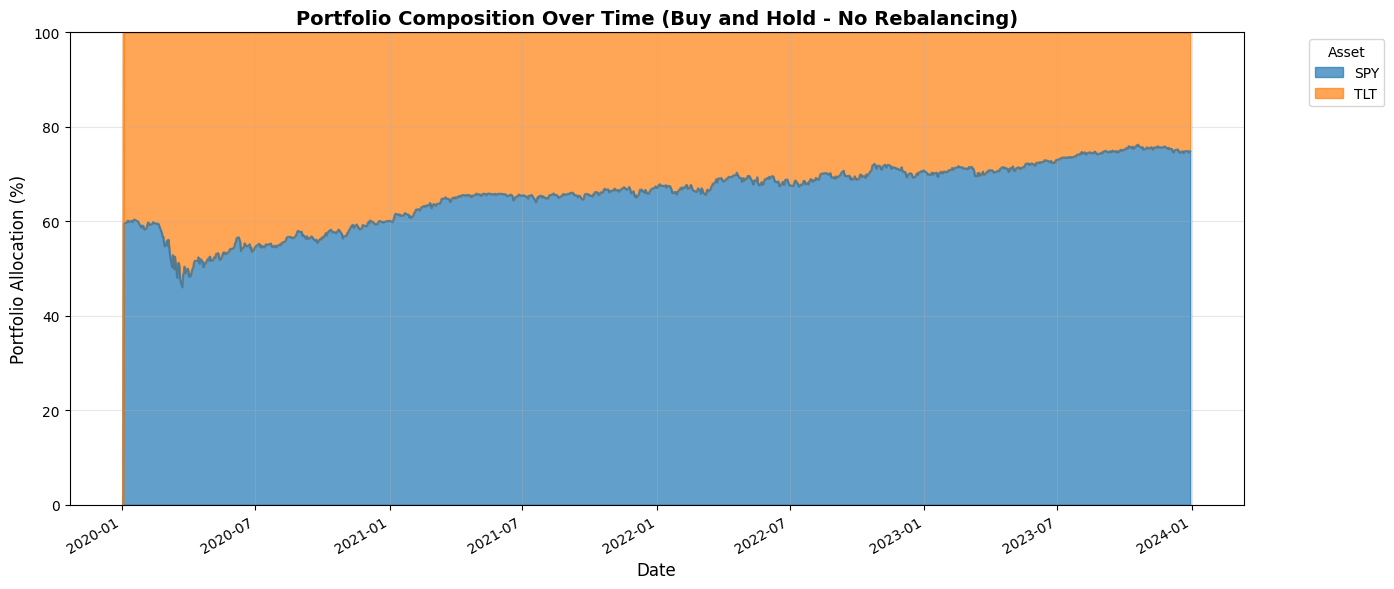


Portfolio Allocation Drift:
Asset         Initial %      Final %        Drift
------------------------------------------------------------
SPY                nan%        74.8%        +nan%
TLT                nan%        25.2%        +nan%


In [8]:
# Extract position values over time
position_values = pd.DataFrame(index=results.index)

for date, row in results.iterrows():
    if row['positions']:
        for pos in row['positions']:
            if hasattr(pos['sid'], 'symbol'):
                symbol_name = pos['sid'].symbol
                # Position value = amount * current price
                position_values.loc[date, symbol_name] = pos['amount'] * pos['last_sale_price']

# Fill NaN with 0
position_values = position_values.fillna(0)

# Calculate percentage allocation
total_value = position_values.sum(axis=1)
position_pcts = position_values.div(total_value, axis=0) * 100

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(14, 6))
position_pcts.plot.area(ax=ax, alpha=0.7, stacked=True)
ax.set_ylabel('Portfolio Allocation (%)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Portfolio Composition Over Time (Buy and Hold - No Rebalancing)', fontsize=14, fontweight='bold')
ax.legend(title='Asset', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 100])
plt.tight_layout()
plt.show()

# Show initial vs final allocations
print("\nPortfolio Allocation Drift:")
print("="*60)
print(f"{'Asset':<10} {'Initial %':>12} {'Final %':>12} {'Drift':>12}")
print("-"*60)
for symbol_name in portfolio_symbols:
    if symbol_name in position_pcts.columns:
        initial = position_pcts[symbol_name].iloc[0]
        final = position_pcts[symbol_name].iloc[-1]
        drift = final - initial
        print(f"{symbol_name:<10} {initial:>11.1f}% {final:>11.1f}% {drift:>+11.1f}%")
print("="*60)

## Pyfolio Analysis

Comprehensive performance analysis using pyfolio library.

In [9]:
# Import pyfolio and suppress matplotlib info warnings
import warnings
warnings.filterwarnings('ignore')

# Suppress matplotlib.category INFO messages (cosmetic warnings from pyfolio)
import logging
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

try:
    import pyfolio as pf
    print("✓ Pyfolio imported successfully")
except ImportError:
    print("⚠️  Pyfolio not installed. Install with: pip install pyfolio-reloaded")
    raise

✓ Pyfolio imported successfully


In [10]:
# Extract returns and positions for pyfolio
returns = results['returns']

# Extract positions (pyfolio needs DOLLAR VALUES, not share counts)
# KEY INSIGHT: row['positions'] contains ONLY stock positions, NOT cash
# Cash is stored separately in the results DataFrame
positions_data = []

for date, row in results.iterrows():
    pos_dict = {}
    
    # Get cash from results DataFrame (if available)
    if 'cash' in results.columns:
        pos_dict['cash'] = row['cash']
    
    # Iterate through ALL positions (they're all stocks, no cash in this list)
    if row['positions']:
        for pos in row['positions']:
            # Position is a dict with keys: sid, amount, cost_basis, last_sale_price
            sid = pos['sid']
            amount = pos['amount']  # number of shares
            last_sale_price = pos['last_sale_price']  # price per share
            
            # Get symbol from sid (Equity object)
            if hasattr(sid, 'symbol'):
                symbol = sid.symbol
                # Store dollar value (shares * price) for pyfolio
                pos_dict[symbol] = amount * last_sale_price
    
    if pos_dict:
        positions_data.append((date, pos_dict))

if positions_data:
    positions = pd.DataFrame([p[1] for p in positions_data],
                            index=[p[0] for p in positions_data])
    # Fill NaN values with 0 (when a position doesn't exist on certain dates)
    positions = positions.fillna(0)
else:
    positions = None

# Extract transactions
transactions_list = []
for date, row in results.iterrows():
    if row['transactions']:
        for txn in row['transactions']:
            # Transaction is a dict with sid, amount, price
            sid = txn['sid']
            symbol = sid.symbol if hasattr(sid, 'symbol') else str(sid)
            
            transactions_list.append({
                'symbol': symbol,
                'amount': txn['amount'],
                'price': txn['price'],
                'value': txn['amount'] * txn['price'],
            })

if transactions_list:
    transactions_pf = pd.DataFrame(transactions_list,
                               index=[date for date, row in results.iterrows()
                                     if row['transactions'] for _ in row['transactions']])
else:
    transactions_pf = None

print(f"✓ Data prepared for pyfolio")
print(f"  Returns: {len(returns)} days")
if positions is not None:
    print(f"  Positions: {len(positions)} days, {len(positions.columns)} assets ({', '.join(positions.columns)})")
    print(f"\n  Sample position values (first date):")
    for col in positions.columns:
        print(f"    {col}: ${positions[col].iloc[0]:,.2f}")
else:
    print(f"  Positions: None")
print(f"  Transactions: {len(transactions_pf) if transactions_pf is not None else 0} trades")

✓ Data prepared for pyfolio
  Returns: 1006 days
  Positions: 1006 days, 3 assets (cash, SPY, TLT)

  Sample position values (first date):
    cash: $100,000.00
    SPY: $0.00
    TLT: $0.00
  Transactions: 2 trades



PYFOLIO TEARSHEET: SPY (60%) + TLT (40%)



Start date,2020-01-02
End date,2023-12-29
Total months,47
,Backtest
Annual return,5.715%
Cumulative returns,24.841%
Annual volatility,14.042%
Sharpe ratio,0.47
Calmar ratio,0.21
Stability,0.04
Max drawdown,-27.027%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.03,2021-12-27,2022-10-14,NaT,NaN
1,17.65,2020-02-20,2020-03-18,2020-06-05,76
2,6.79,2020-09-02,2020-10-30,2020-12-08,70
3,4.92,2021-01-25,2021-03-04,2021-04-08,53
4,4.49,2021-09-02,2021-09-30,2021-10-28,41


Stress Events,mean,min,max
Covid,0.02%,-5.35%,5.03%


Top 10 long positions of all time,max
SPY,76.29%
TLT,54.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SPY,76.29%
TLT,54.00%


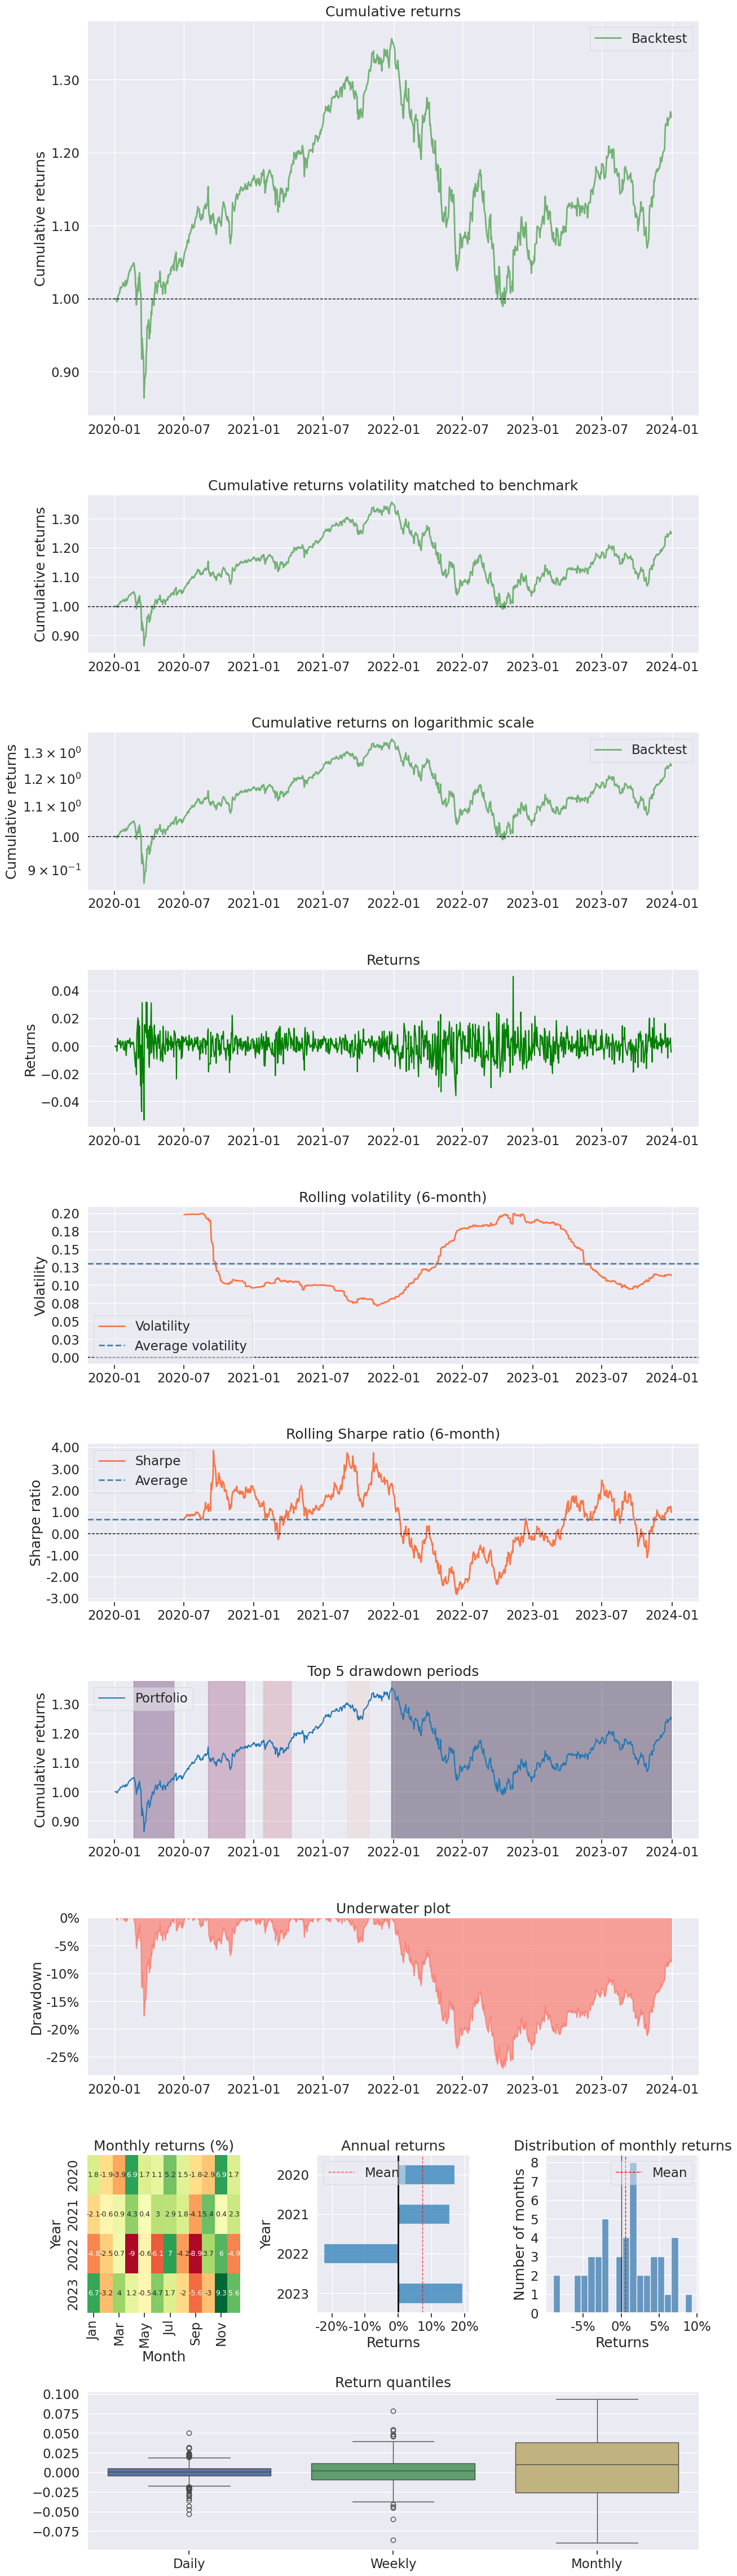

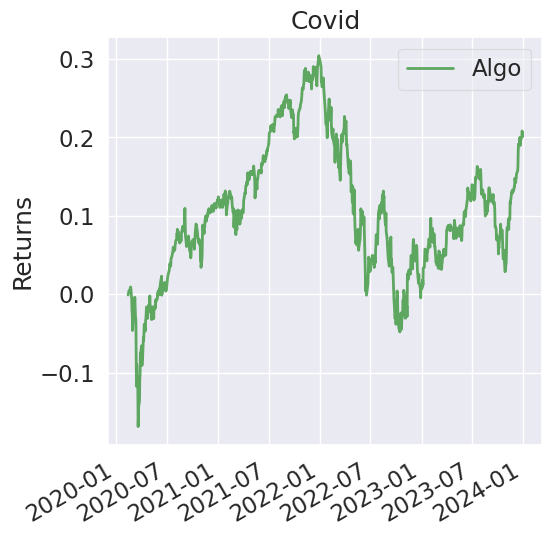

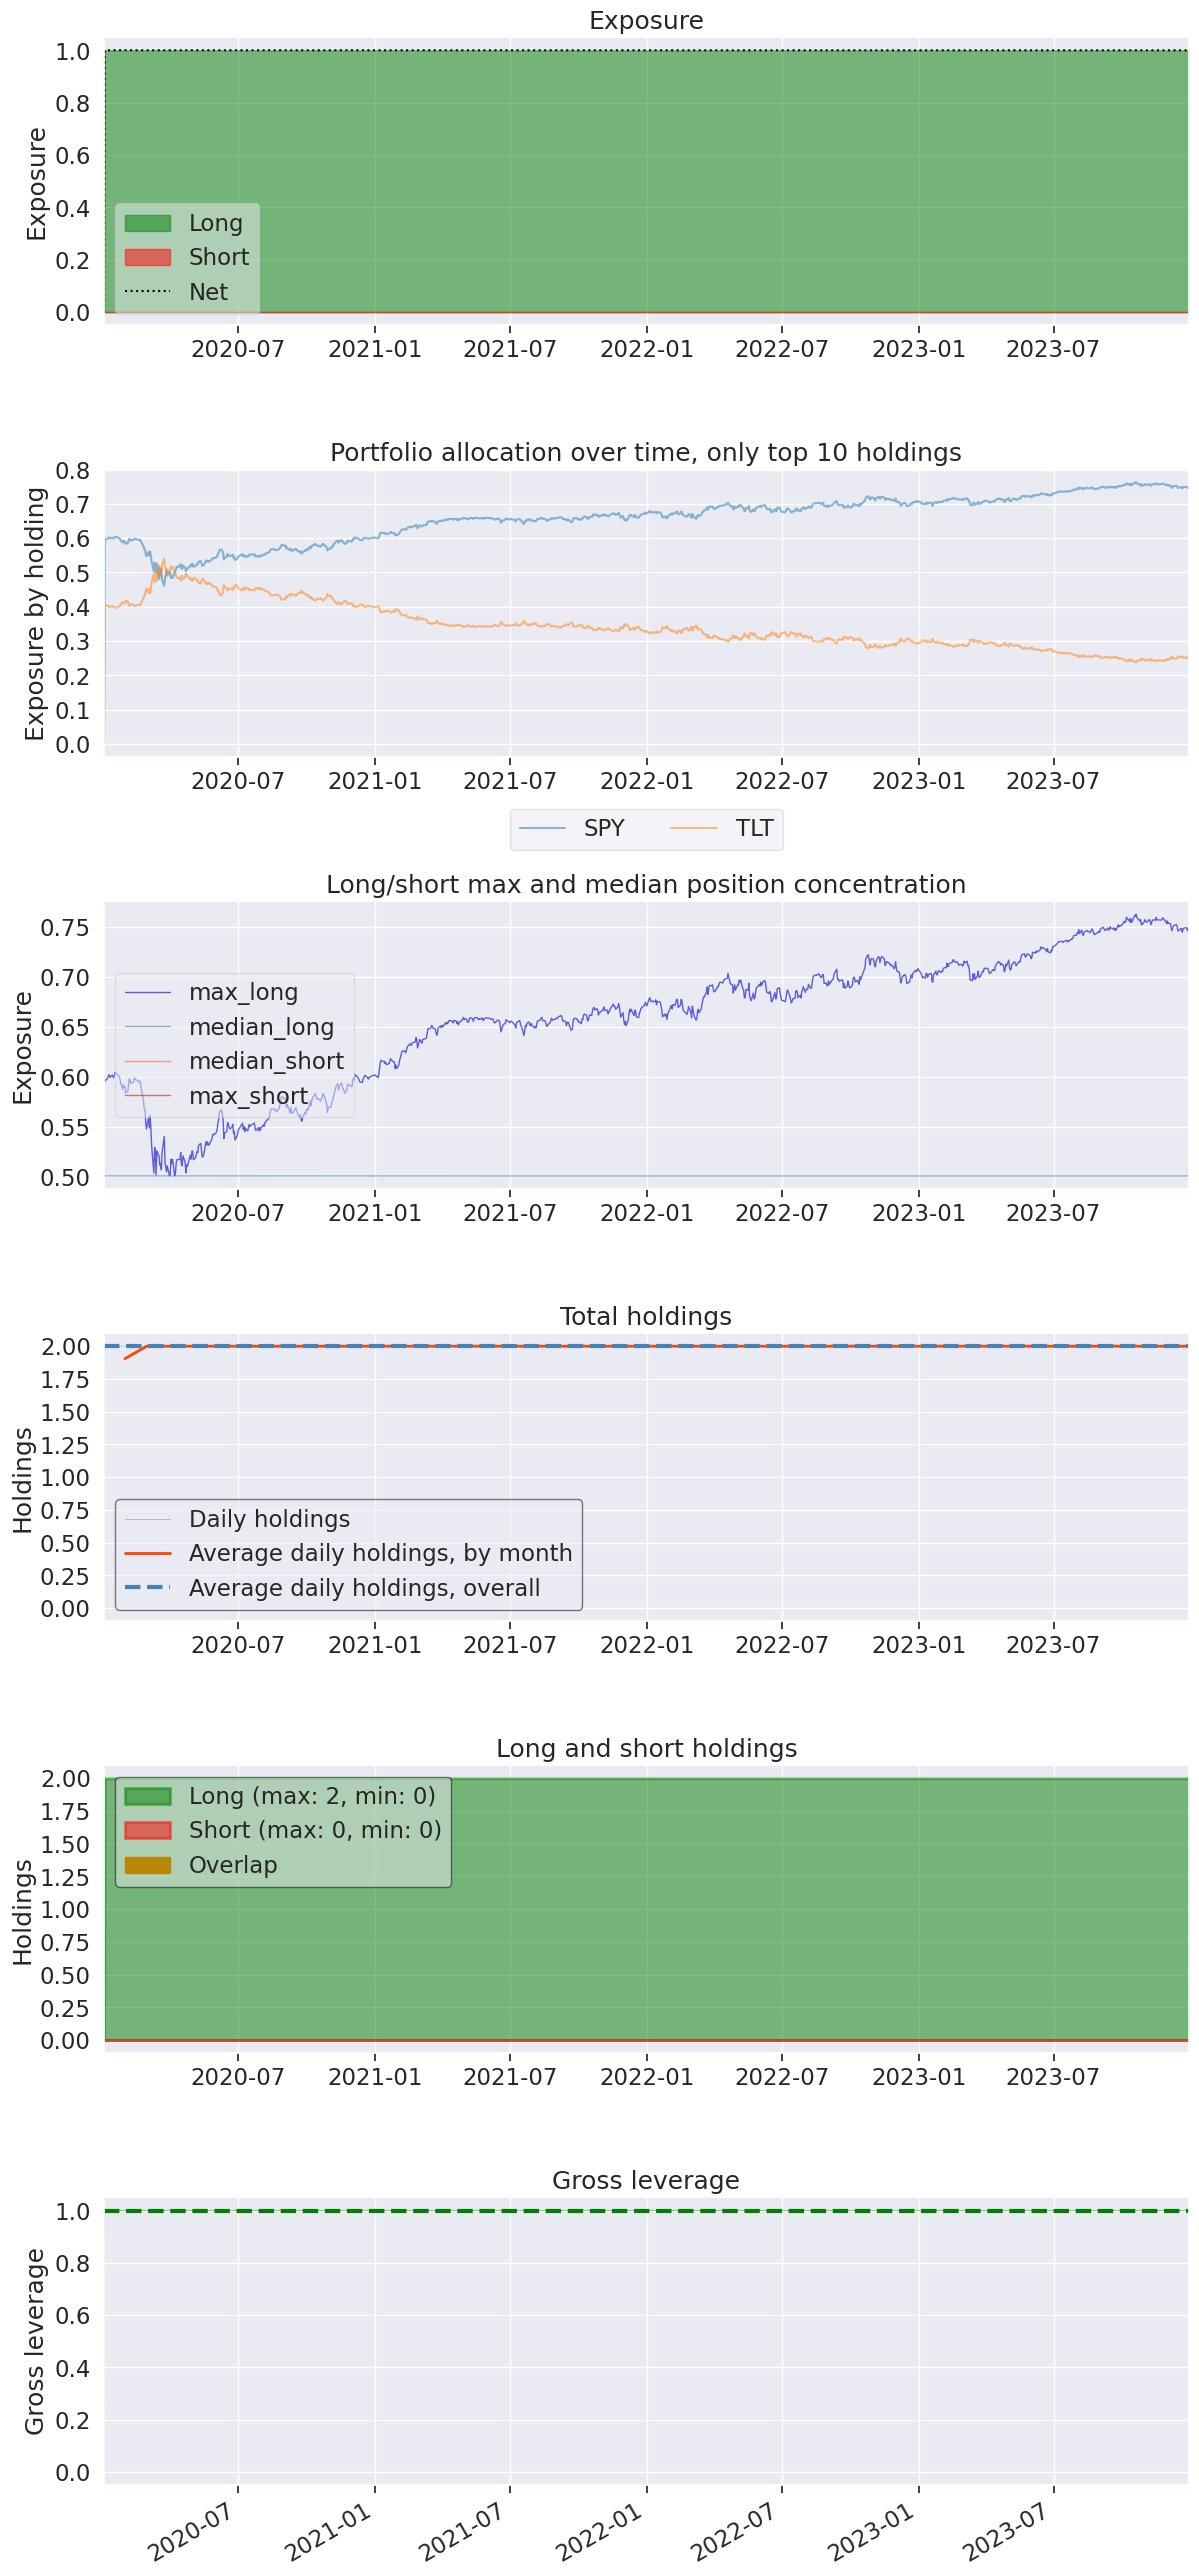

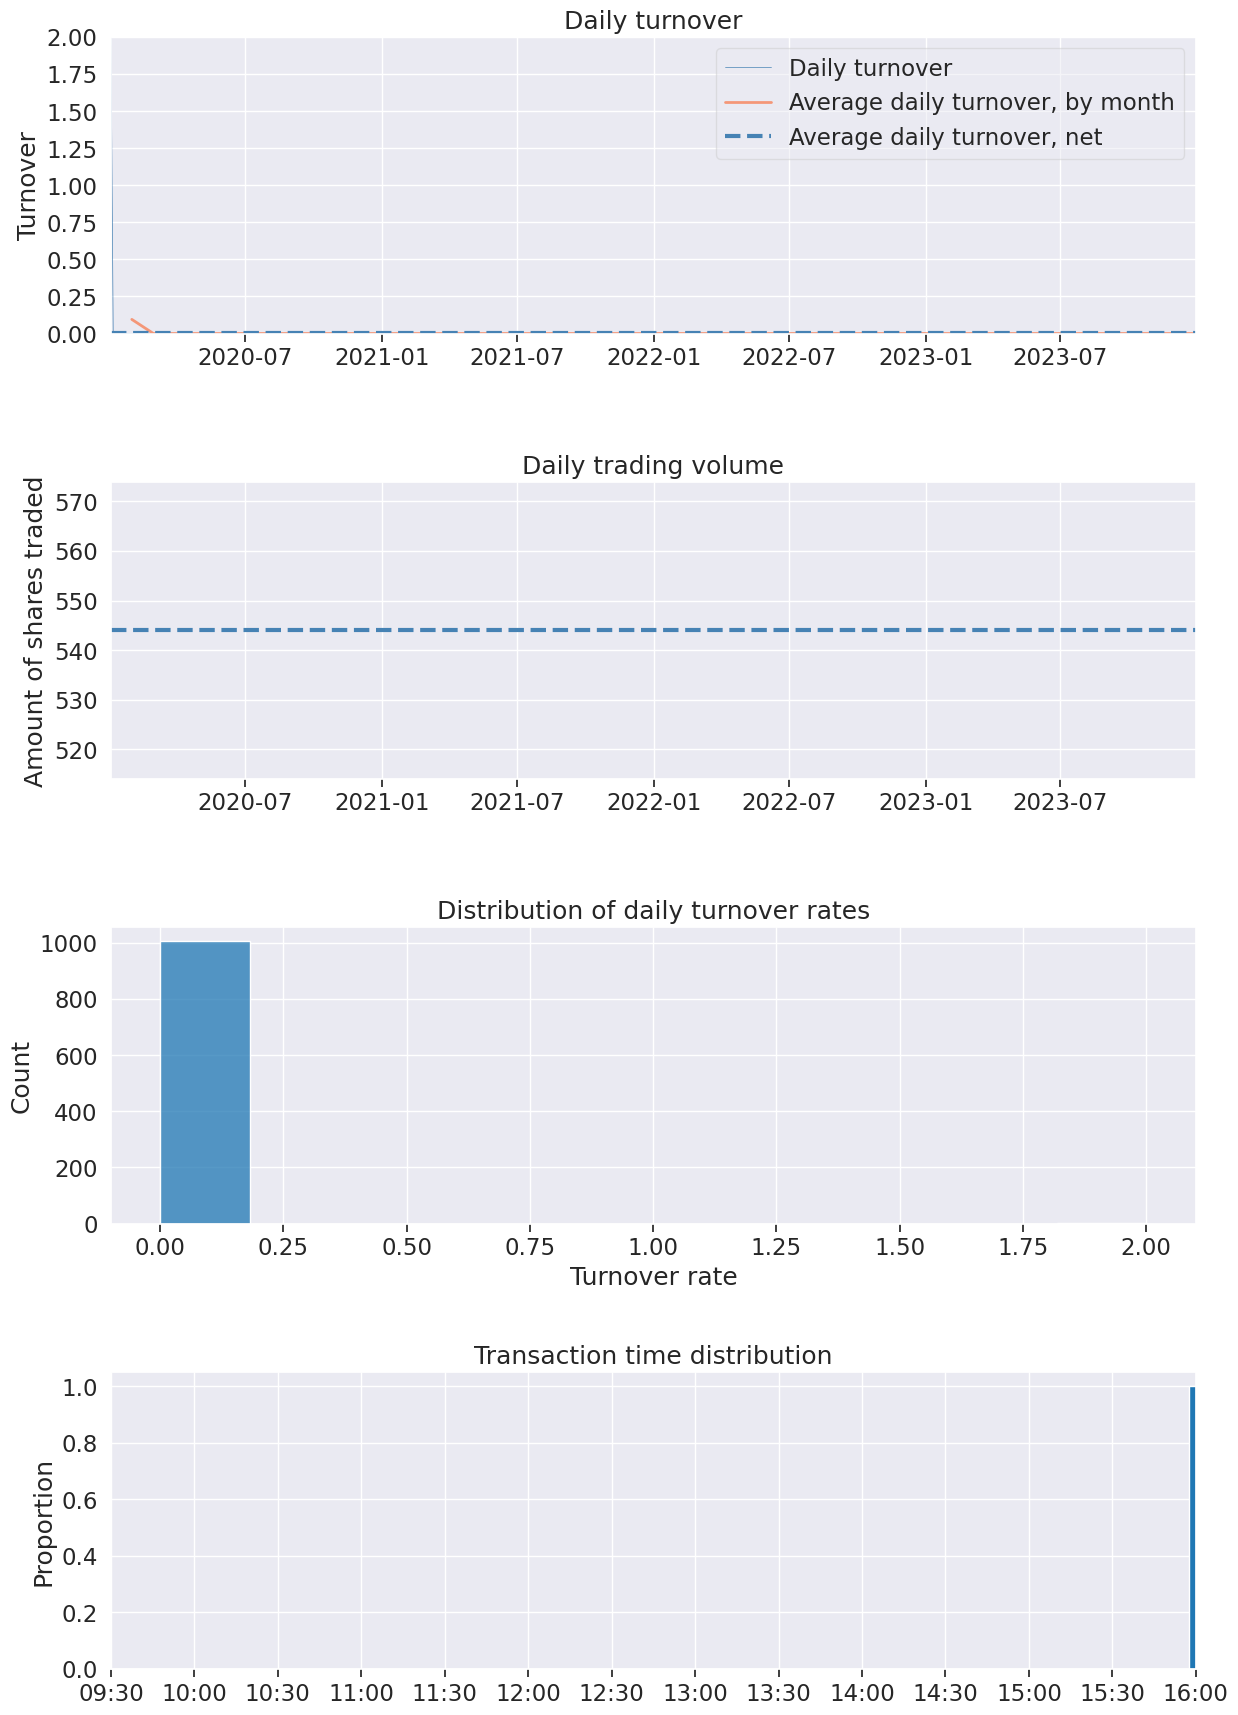

In [11]:
# Generate comprehensive tearsheet
portfolio_name = " + ".join([f"{s} ({w*100:.0f}%)" for s, w in PORTFOLIO.items()])
print(f"\n{'='*60}")
print(f"PYFOLIO TEARSHEET: {portfolio_name}")
print(f"{'='*60}\n")

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions_pf,
    live_start_date=None,
    round_trips=False,
    estimate_intraday=False,
)

In [12]:
# Calculate and display key performance metrics
annual_return = pf.timeseries.annual_return(returns)
sharpe_ratio = pf.timeseries.sharpe_ratio(returns)
max_drawdown = pf.timeseries.max_drawdown(returns)
sortino_ratio = pf.timeseries.sortino_ratio(returns)
calmar_ratio = pf.timeseries.calmar_ratio(returns)
volatility = pf.timeseries.annual_volatility(returns)

print("\n" + "="*60)
print(f"PORTFOLIO KEY PERFORMANCE METRICS")
print("="*60)
print(f"Annual Return: {annual_return*100:.2f}%")
print(f"Annual Volatility: {volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print("="*60)

# Calculate cumulative returns
cum_returns = pf.timeseries.cum_returns(returns)
total_return = cum_returns.iloc[-1]
print(f"\nTotal Return: {total_return*100:.2f}%")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")


PORTFOLIO KEY PERFORMANCE METRICS
Annual Return: 5.72%
Annual Volatility: 14.04%
Sharpe Ratio: 0.47
Sortino Ratio: 0.64
Calmar Ratio: 0.21
Max Drawdown: -27.03%

Total Return: 24.84%
Final Portfolio Value: $124,840.76


## Summary

This notebook demonstrates portfolio allocation with custom weights:
- **Configurable**: Define any portfolio with custom weight allocations
- **Buy and Hold**: Single purchase with no rebalancing (shows drift over time)
- **Multi-Asset**: Track individual asset performance within the portfolio
- **Comprehensive Analysis**: Full pyfolio tearsheet with risk metrics

## Next Steps

**To try a different portfolio:**
1. Go to the "Portfolio Configuration" section
2. Modify the `PORTFOLIO` dictionary with your desired symbols and weights
3. Ensure weights sum to 1.0 (100%)
4. Re-run all cells

**Experiment with:**
- Different asset combinations (stocks, bonds, ETFs, commodities)
- Various weight allocations (equal weight, market cap weighted, risk parity)
- Different time periods (modify `start` and `end` dates)
- Compare portfolios side-by-side by running the notebook multiple times

**Compare against:**
- Single-asset strategies (see `02_buy_and_hold_strategy.ipynb`)
- Active strategies (see `03_moving_average_crossover.ipynb`)
- Risk-adjusted returns using Sharpe ratio

**Advanced Ideas:**
- Add periodic rebalancing (modify `handle_data` to rebalance monthly/quarterly)
- Implement dynamic allocation based on volatility or momentum
- Test risk parity approaches (equal risk contribution)
- Compare efficient frontier allocations